In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = (7,5)

In [39]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
df = ratings.merge(movies, on='movieId').drop(columns=['timestamp'])

In [40]:
movies.head(1)

movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy

In [41]:
ratings.head(1)

userId  movieId  rating  timestamp
0       1        1     4.0  964982703

In [42]:
df.head(1)

userId  movieId  rating             title  \
0       1        1     4.0  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy

## EDA 

### Numeric information about number of ratings, user, avrage number of rating and etc..

In [43]:
number_of_rating = len(ratings)
number_of_users = ratings['userId'].nunique()
number_of_movies = movies['movieId'].nunique()
avg_number_of_rating_per_user = ratings.groupby('userId')['rating'].size().mean()
avg_number_of_rating_per_movie = ratings.groupby('movieId').size().mean()
avg_rating_per_movie = ratings['rating'].mean()

print(f'Number of ratings in this dataset: {number_of_rating}')
print(f'Number of users that rated movies: {number_of_users}')
print(f'Number of Movies in this dataset: {number_of_movies}')
print(f'Average number of rating per user: {round(avg_number_of_rating_per_user)}')
print(f'Average number of rating per movie: {round(avg_number_of_rating_per_movie)}')
print(f'Average rating of rating each movie: {round(avg_rating_per_movie, 1)}')

Number of ratings in this dataset: 100836
Number of users that rated movies: 610
Number of Movies in this dataset: 9742
Average number of rating per user: 165
Average number of rating per movie: 10
Average rating of rating each movie: 3.5


### Distribution of rating to visualize the validity of dataset. Since our data is not distributed in specific rating, we can be sure we can work with this dataset to make a movie recommendation system

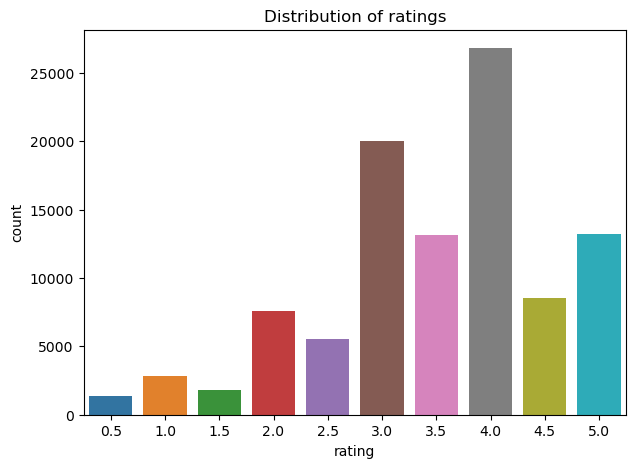

In [44]:
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of ratings')
plt.show()

### Most rated movies visualization

In [45]:
most_rated_movies = df['title'].value_counts()[0:10]

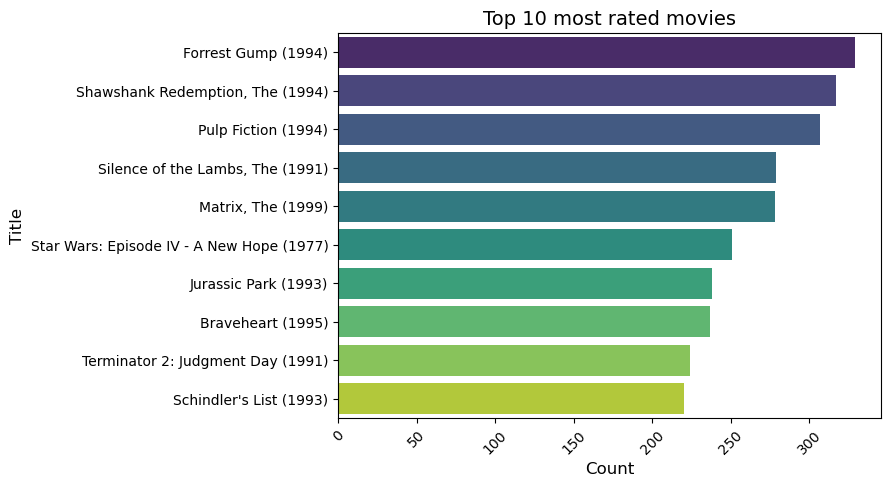

In [46]:
sns.barplot(y=most_rated_movies.index, x=most_rated_movies.values, palette='viridis')
plt.title('Top 10 most rated movies', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Title', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### Bayesian Average
$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior $m$ will be the average mean rating across all movies. By defintion, C represents "the typical data set size". Let's make $C$ be the average number of ratings for a given movie.

In [47]:
movie_stat = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stat.head()

count      mean
movieId                 
1          215  3.920930
2          110  3.431818
3           52  3.259615
4            7  2.357143
5           49  3.071429

In [48]:
C = movie_stat['count'].mean()
m = movie_stat['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [49]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings = bayesian_avg_ratings.merge(movies, on='movieId')
bayesian_avg_ratings.head()

movieId  rating                               title  \
0        1   3.891                    Toy Story (1995)   
1        2   3.417                      Jumanji (1995)   
2        3   3.260             Grumpier Old Men (1995)   
3        4   2.898            Waiting to Exhale (1995)   
4        5   3.105  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

### Top 10 highest rated movies based on Bayesian Average

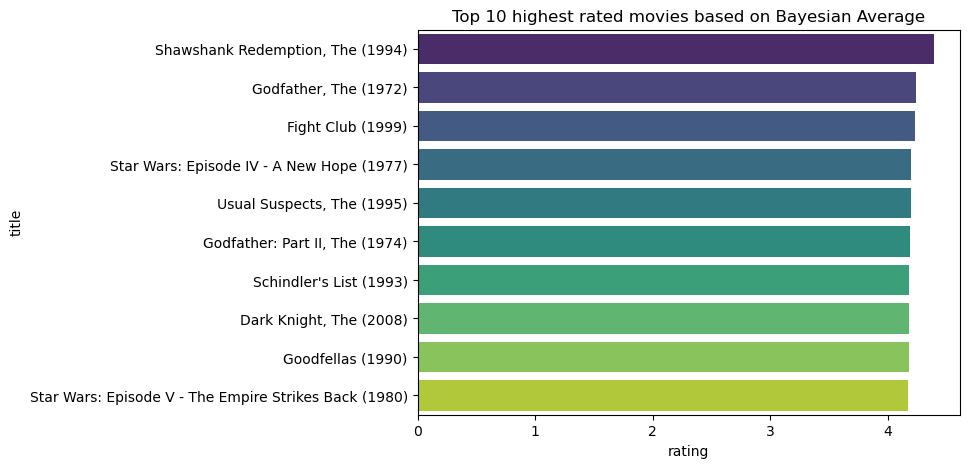

In [50]:
bayesian_avg_highest_visualization = bayesian_avg_ratings.sort_values(by='rating', ascending=False)[0:10]
sns.barplot(x='rating', y='title', data=bayesian_avg_highest_visualization, palette='viridis')
plt.title('Top 10 highest rated movies based on Bayesian Average')
plt.show()

### Top 10 lowest rated movies based on Bayesian Average

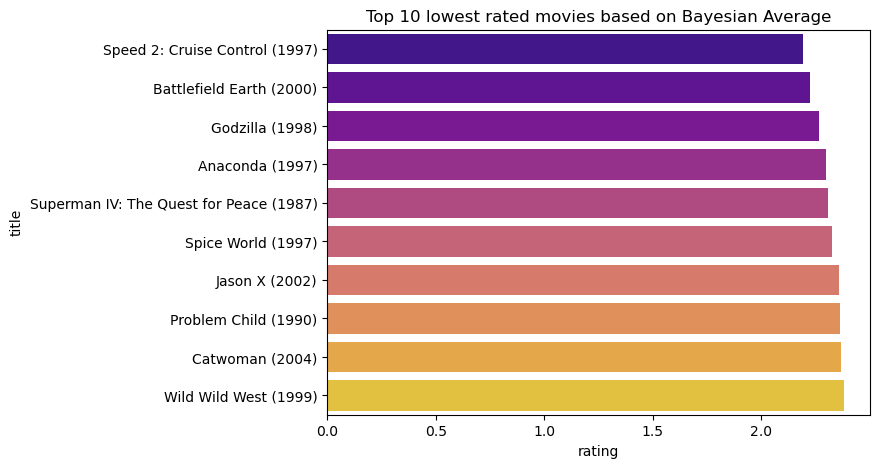

In [51]:
bayesian_avg_lowest_visualization = bayesian_avg_ratings.sort_values(by='rating')[0:10]
sns.barplot(x='rating', y='title', data=bayesian_avg_lowest_visualization, palette='plasma')
plt.title('Top 10 lowest rated movies based on Bayesian Average')
plt.show()

### Analysing the movies genres

In [52]:
df.iloc[0, -1]

'Adventure|Animation|Children|Comedy|Fantasy'

In [53]:
if type(df.iloc[0, -1]) is type('Hello'):
    df['genres'] = df['genres'].apply(lambda genre: genre.split('|'))

In [54]:
from collections import Counter

genre_frequency = Counter([g for genres in df['genres'] for g in genres])
genre_frequency = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency.columns = ['genre', 'count']

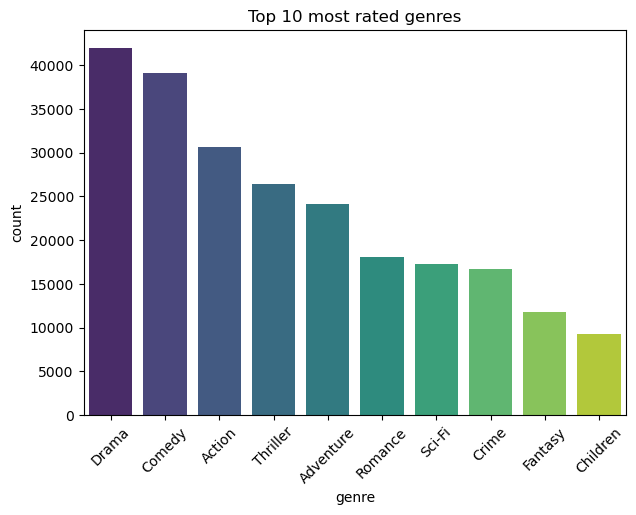

In [55]:
top_10_most_rated_genre = genre_frequency.sort_values(by='count', ascending=False)[0:10]
sns.barplot(x='genre', y='count', data=top_10_most_rated_genre, palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 most rated genres')
plt.show()

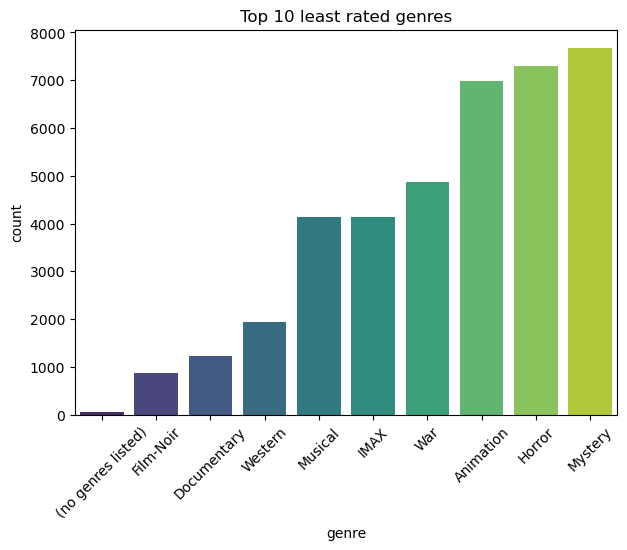

In [56]:
top_10_least_rated_genre = genre_frequency.sort_values(by='count', ascending=True)[0:10]
sns.barplot(x='genre', y='count', data=top_10_least_rated_genre, palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 least rated genres')
plt.show()

### Creating features

## Movie Recommendation Matrix (Features Matrix)

### Structure of the Recommendation Matrix
In a movie recommendation system, the recommendation matrix (also known as the features matrix) is a crucial component. This matrix is typically constructed with the following structure:

- **Rows (User IDs)**: Each row represents a unique user.
- **Columns (Movie IDs)**: Each column represents a unique movie.
- **Values (Ratings)**: The values in the matrix represent the ratings that users have given to movies. If a user has rated a movie, the corresponding cell in the matrix contains the rating value. If a user has not rated a movie, the cell typically contains a zero or is left empty.

### Example Matrix
Hereâ€™s an example to illustrate the concept:

| User ID \ Movie ID | Movie 1 | Movie 2 | Movie 3 |
|--------------------|---------|---------|---------|
| User 1             | 5       | 4       | 0       |
| User 2             | 0       | 3       | 0       |
| User 3             | 2       | 0       | 0       |
| User 4             | 0       | 0       | 5       |

- **User 1** has rated **Movie 1** with a 5 and **Movie 2** with a 4.
- **User 2** has rated **Movie 2** with a 3.
- **User 3** has rated **Movie 1** with a 2.
- **User 4** has rated **Movie 3** with a 5.
- Cells with a 0 indicate that the user has not rated that movie.

### Sparsity in the Matrix
In real-world scenarios, these matrices are typically very large and sparse. Sparsity refers to the condition where most of the elements in the matrix are zeros (indicating no rating).

### Using Sparse Matrix Representation
Given the high level of sparsity in user-item rating matrices, it is inefficient to store and process these matrices in a dense format (i.e., with all the zeros explicitly stored). Instead, we use sparse matrix representations for the following reasons:

1. **Memory Efficiency**:
   - Sparse matrices store only the non-zero elements and their positions, which significantly reduces memory usage. This is particularly important for large datasets with millions of users and items.

2. **Computational Efficiency**:
   - Many operations on sparse matrices can be performed more efficiently because the algorithms only need to process the non-zero elements. This leads to faster computations and reduced computational costs.

3. **Scalability**:
   - Sparse matrices enable the handling of larger datasets that would be impractical to store and process as dense matrices. This is crucial for modern recommendation systems that deal with vast amounts of data.

### Example of Sparse Matrix
Using the example matrix above, the sparse representation would store only the non-zero ratings:

| Row (User ID) | Column (Movie ID) | Value (Rating) |
|---------------|--------------------|----------------|
| 0             | 0                  | 5              |
| 0             | 1                  | 4              |
| 1             | 1                  | 3              |
| 2             | 0                  | 2              |
| 3             | 2                  | 5              |

This representation is much more compact and efficient for storage and computation, especially when the matrix is highly sparse.

### Conclusion
The use of a sparse matrix is essential in the context of movie recommendation systems to efficiently manage and process the large, sparse datasets typical of user-item ratings. This allows for better performance and scalability in delivering personalized recommendations.


In [57]:
from scipy.sparse import csr_matrix

def create_features_X(data_frame):

    M = data_frame['userId'].nunique()
    N = data_frame['movieId'].nunique()
    
    user_mapper = dict(zip(np.unique(data_frame['userId']), range(M)))
    movie_mapper = dict(zip(np.unique(data_frame['movieId']), range(N)))

    user_rev_map = dict(zip(range(M), np.unique(data_frame['userId'])))
    movie_rev_map = dict(zip(range(N), np.unique(data_frame['movieId'])))

    user_index = [user_mapper[i] for i in data_frame['userId']]
    movie_index = [movie_mapper[i] for i in data_frame['movieId']]

    X = csr_matrix((df['rating'], (user_index, movie_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_rev_map, movie_rev_map

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_features_X(ratings)

In [58]:
X.shape

(610, 9724)

## Understanding Sparsity Percentage

### What is Sparsity?
Sparsity in the context of a matrix refers to the proportion of zero elements to the total number of elements in the matrix. A high sparsity percentage indicates that most of the elements in the matrix are zeros. In a user-item ratings matrix, high sparsity is common because not every user has rated every item.

### Why Calculate Sparsity?

1. **Memory Efficiency**:
   - Sparse matrices can be stored more efficiently using specialized data structures like Compressed Sparse Row (CSR) format, which save memory and computational resources. Knowing the sparsity helps in choosing the appropriate storage format.

2. **Algorithm Selection**:
   - Some machine learning algorithms are designed to handle sparse data efficiently. Calculating the sparsity can guide the selection of algorithms and methods for tasks such as collaborative filtering and recommendation systems, ensuring better performance and scalability.

3. **Performance Optimization**:
   - High sparsity can affect the performance of certain algorithms, leading to longer computation times and higher resource usage. By understanding the sparsity, we can optimize and tune algorithms to handle sparse data effectively, improving overall performance.

4. **Insight into Data**:
   - Sparsity provides valuable insight into the data collection process. For instance, high sparsity in a recommendation system might indicate that users interact with only a small subset of items. This information can be useful for understanding user behavior and preferences, which in turn can inform strategies for data collection, user engagement, and personalized recommendations.

### Example:
If we calculate the sparsity percentage and find that it is 1.7%, it means that only 1.7% of the total possible ratings have been provided. This indicates a very high sparsity, which is typical in real-world recommendation systems because users rate only a small fraction of the available items.

Understanding and managing sparsity is crucial for developing efficient and effective recommendation systems and for making informed decisions based on the user-item interaction data.


In [59]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


It indicates that in a different (likely much larger) dataset, only 1.7% of the total possible ratings have been provided, showing a very high sparsity. High sparsity is typical in real-world recommendation systems because users rate only a small fraction of the available items.

## Recommendation System Using k-Nearest Neighbors (kNN)

### Introduction to Recommendation Systems
Recommendation systems are designed to suggest items (such as movies, books, or products) to users based on various data sources and algorithms. These systems aim to enhance the user experience by providing personalized recommendations, which can lead to increased engagement and satisfaction.

### Collaborative Filtering
One common approach to building recommendation systems is collaborative filtering, which leverages user-item interactions (e.g., ratings) to make recommendations. Collaborative filtering operates under the assumption that users who have agreed in the past will agree in the future. There are two primary types of collaborative filtering:
- **User-based collaborative filtering**: Recommends items by finding users similar to the target user and suggesting items those similar users have liked.
- **Item-based collaborative filtering**: Recommends items by finding items similar to those the target user has liked in the past.

### k-Nearest Neighbors (kNN) for Recommendations
k-Nearest Neighbors (kNN) is a simple and effective algorithm that can be used for both user-based and item-based collaborative filtering. The kNN algorithm identifies the 'k' most similar users or items based on a chosen similarity metric, such as cosine similarity, Euclidean distance, or Pearson correlation.

### Why Use kNN in Recommendation Systems?
1. **Simplicity**: kNN is straightforward to understand and implement, making it a good starting point for building recommendation systems.
2. **Effectiveness**: Despite its simplicity, kNN can provide high-quality recommendations, especially when there are clear patterns in the data.
3. **Flexibility**: kNN can be easily adapted to different types of recommendation tasks (user-based or item-based) by changing the way similarity is computed.
4. **Non-parametric**: kNN does not make assumptions about the underlying data distribution, making it a versatile tool for various datasets.

### kNN for Item-Based Collaborative Filtering
In item-based collaborative filtering using kNN, we aim to recommend items (e.g., movies) similar to those the user has already rated highly. The process involves the following steps:
1. **Matrix Construction**: Create a user-item matrix where rows represent users, columns represent items, and values represent user ratings.
2. **Transpose the Matrix**: For item-based filtering, we transpose the matrix so that items are represented as rows.
3. **Compute Similarities**: Use the kNN algorithm to compute similarities between items based on user ratings. The similarity can be measured using metrics like cosine similarity.
4. **Find Neighbors**: For a given item, find the 'k' most similar items using the kNN algorithm.
5. **Generate Recommendations**: Recommend the similar items to users based on the identified neighbors.

### Conclusion
Using kNN in recommendation systems allows us to leverage the collective intelligence of user interactions to provide personalized and relevant recommendations. While kNN is not the only approach to building recommendation systems, its simplicity, effectiveness, and flexibility make it a popular choice for many applications. As data grows and more sophisticated algorithms emerge, kNN remains a valuable tool in the recommendation system toolkit.


In [108]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, n):
    """
    Find n similar movies based on the given movie
    
    Parameters
    ----------
    movieId : int
        The ID of the movie of interest.
    n : int
        The number of similar movies to retrieve.
    
    Returns
    -------
    neighbour_ids : list of str
        A list of n similar movie names.
    """
    entered_movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f'Since you watched {entered_movie_title}, you make like following movies:')
    movies_idxs = find_similar_movies_idx(movie_id, 
                                          X, 
                                          movie_mapper, 
                                          movie_inv_mapper, 
                                          n + 1)
    return movies[movies['movieId'].isin(movies_idxs)].sort_values(by='title')

def find_similar_movies_idx(movieId, spare_matrix, movie_mapper, movie_inv_mapper, n, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Parameters
    ----------
    movie_id : int
        The ID of the movie of interest.
    X : csr_matrix
        The user-item utility matrix (transposed so that movies are rows).
    movie_mapper : dict
        A dictionary mapping movie IDs to matrix column indices.
    movie_inv_mapper : dict
        A dictionary mapping matrix column indices back to movie IDs.
    k : int
        The number of similar movies to retrieve.
    metric : str, optional
        The distance metric to use for kNN calculations (default is 'cosine').
    
    Returns
    -------
    neighbour_ids : list of int
        A list of k similar movie IDs.
    """
    
    spare_matrix = spare_matrix.T
    similar_movies_idx = []

    movie_idx = movie_mapper[movieId]
    movie_vec = spare_matrix[movie_idx]

    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)

    knn_model = NearestNeighbors(n_neighbors=n+1, metric=metric, algorithm='brute')
    knn_model.fit(spare_matrix)
    neighbors = knn_model.kneighbors(movie_vec, return_distance=False)

    for i in range(0,n):
        movie_id = neighbors.item(i)
        similar_movies_idx.append(movie_inv_mapper[movie_id])

    similar_movies_idx.pop(0)

    return similar_movies_idx

In [109]:
find_similar_movies(1, 10)

Since you watched Toy Story (1995), you make like following movies:


movieId                                              title  \
123       150                                   Apollo 13 (1995)   
969      1270                          Back to the Future (1985)   
314       356                                Forrest Gump (1994)   
615       780               Independence Day (a.k.a. ID4) (1996)   
418       480                               Jurassic Park (1993)   
546       648                         Mission: Impossible (1996)   
257       296                                Pulp Fiction (1994)   
224       260          Star Wars: Episode IV - A New Hope (1977)   
911      1210  Star Wars: Episode VI - Return of the Jedi (1983)   
2355     3114                                 Toy Story 2 (1999)   

                                           genres  
123                          Adventure|Drama|IMAX  
969                       Adventure|Comedy|Sci-Fi  
314                      Comedy|Drama|Romance|War  
615              Action|Adventure|Sci-Fi|Thriller  
418              Action|Adventure|Sci-Fi|Thriller  
546             Action|Adventure|Mystery|Thriller  
257                   Comedy|Crime|Drama|Thriller  
224                       Action|Adventure|Sci-Fi  
911                       Action|Adventure|Sci-Fi  
2355  Adventure|Animation|Children|Comedy|Fantasy